In [7]:
import pandas as pd
from Bio import SeqIO
import csv
import glob
import os
import sys
import re
from pathlib import Path
from collections import Counter, defaultdict
from itertools import groupby
import matplotlib.pyplot as plt
import seaborn as sns


In [8]:

# generate all possible k-mers
def generate_kmers(k):
    bases = ['A', 'U', 'G', 'C']
    return [''.join(p) for p in itertools.product(bases, repeat=k)]

# feature extraction
def seq_features(seq, k_list=[3, 5], pos_k_list=[1, 2], pos_range=range(-4, 5)):
    seq = str(seq).upper().replace('T', 'U')
    length = len(seq)
    mid = length // 2 #  121 nt, mid = 60 (0-based), so position 61

    features = {}

    # central position is U 
    if length != 121 or seq[mid] != 'U':
        return None  #invalid sequence skipping

    # Centred 5-mer (around pseudouridine)
    features["centred_5mer"] = seq[mid - 2: mid + 3]

    # Nucleotide composition
    counts = Counter(seq)
    for base in ['A', 'U', 'G', 'C']:
        features[f'perc_{base}'] = counts.get(base, 0) / length if length else 0
    features['gc_content'] = (counts.get('G', 0) + counts.get('C', 0)) / length if length else 0

    # Dinucleotide frequencies
    total_dinucs = max(length - 1, 1)
    for a in 'AUGC':
        for b in 'AUGC':
            dinuc = a + b
            features[f'dinuc_{dinuc}'] = sum(seq[i:i+2] == dinuc for i in range(length-1)) / total_dinucs

    # Position-aware k-mers
    for k in pos_k_list:
        for offset in range(-4, 5):  # window around center - later can be widen to -10 to 11
            start = mid + offset
            end = start + k
            if 0 <= start < end <= length: # conditional check - prevent seq that dont exist
                kmer = seq[start:end]
                if all(base in "AUGC" for base in kmer):
                    features[f'k{k}_pos{offset}_{kmer}'] = 1

    return features


In [2]:
def extract_features(fasta_path, label):
    records = list(SeqIO.parse(fasta_path, "fasta"))
    features = []
    for record in records:
        feats = seq_features(record.seq)
        feats['transcript_id'] = record.id
        feats['label'] = label
        features.append(feats)
    return pd.DataFrame(features)


In [5]:
# HEK293 fasta seq

# Quantitative profiling of pseudouridylation landscape in the human transcriptome
fasta_hk_qb_pos = "/nobackup/tjxz93/pse_project/updated_ERNIE/ERNIE-RNA/data/ss_prediction/hek_qb.fasta"
fasta_hk_qb_neg = "/nobackup/tjxz93/pse_project/updated_ERNIE/ERNIE-RNA/data/ss_prediction/hek_qb_negatives.fasta"

# TRUB1 is the predominant pseudouridine synthase acting on mammalian mRNA via a predictable and conserved code
fasta_hek_csv_pos = "/nobackup/tjxz93/pse_project/updated_ERNIE/ERNIE-RNA/data/ss_prediction/pus7_hek_csv_ENST_U_only.fasta"
fasta_hek_csv_neg = "/nobackup/tjxz93/pse_project/updated_ERNIE/ERNIE-RNA/data/ss_prediction/other_pus_hek_csv_enst_downsampled.fasta"

# HELA fasta seq

# BID-seq
fasta_bid_seq_pos = "/nobackup/tjxz93/pse_project/updated_ERNIE/ERNIE-RNA/data/ss_prediction/PUS7_positive_sequences_middleU.fa"
fasta_bid_seq_neg = "/nobackup/tjxz93/pse_project/updated_ERNIE/ERNIE-RNA/data/ss_prediction/shControl_sequences_middleU.fa"

# pseudo-seq
fasta_pseudo_seq_pos = "/nobackup/tjxz93/pse_project/updated_ERNIE/ERNIE-RNA/data/ss_prediction/pus7_corrected_pse.fasta"
fasta_pseudo_seq_neg = "/nobackup/tjxz93/pse_project/updated_ERNIE/ERNIE-RNA/data/ss_prediction/pus7_negatives_filtered.fasta"


In [9]:
# used for extracting transcript id only for ML - fro EDA is above
def extract_features(fasta_path, label):
    records = list(SeqIO.parse(fasta_path, "fasta"))
    features = []
    for record in records:
        feats = seq_features(record.seq)
        if feats is not None:
            feats['transcript_id'] = record.id  # This includes both ENST and NM IDs
            feats['label'] = label
            features.append(feats)
        else:
            # log skipped record
            print(f"Skipped: {record.id} (invalid seq)")
    return pd.DataFrame(features)


In [10]:
#########################
# extract features
#########################
df_hk_qb_pos = extract_features(fasta_hk_qb_pos, label=1)
df_hk_qb_neg = extract_features(fasta_hk_qb_neg, label=0)

df_hek_csv_pos = extract_features(fasta_hek_csv_pos, label=1)
df_hek_csv_neg = extract_features(fasta_hek_csv_neg, label=0)

df_bid_seq_pos = extract_features(fasta_bid_seq_pos, label=1)
df_bid_seq_neg = extract_features(fasta_bid_seq_neg, label=0)

df_pseudo_seq_pos = extract_features(fasta_pseudo_seq_pos, label=1)
df_pseudo_seq_neg = extract_features(fasta_pseudo_seq_neg, label=0)

print(">>> Starting sequence feature extraction...")

df_all = pd.concat([
    df_hk_qb_pos,df_hk_qb_neg,
    df_hek_csv_pos,df_hek_csv_neg,
    df_bid_seq_pos,df_bid_seq_neg,
    df_pseudo_seq_pos,df_pseudo_seq_neg
], ignore_index=True)
print(f">>> Sequence extraction done: {df_all.shape[0]} sequences, {df_all.shape[1]} columns")


>>> Starting sequence feature extraction...
>>> Sequence extraction done: 1368 sequences, 177 columns


In [11]:
print("label" in df_all.columns)

True


In [12]:
df_all.head()

,centred_5mer,perc_A,perc_U,perc_G,perc_C,gc_content,dinuc_AA,dinuc_AU,dinuc_AG,dinuc_AC,...,k2_pos1_CA,k2_pos2_AC,k2_pos-2_CC,k2_pos-2_AC,k2_pos2_UC,k2_pos1_CU,k2_pos1_CC,k2_pos-2_UU,k2_pos-2_AA,k2_pos1_CG
0,UGUAG,0.173554,0.123967,0.371901,0.330579,0.702479,0.025000,0.016667,0.083333,0.050000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,UGUAG,0.280992,0.355372,0.231405,0.132231,0.363636,0.066667,0.108333,0.066667,0.041667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,UGUAG,0.223140,0.206612,0.239669,0.330579,0.570248,0.041667,0.041667,0.050000,0.083333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,UGUAG,0.198347,0.264463,0.297521,0.239669,0.537190,0.050000,0.041667,0.075000,0.033333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,UGUAG,0.314050,0.371901,0.190083,0.123967,0.314050,0.091667,0.100000,0.091667,0.033333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df_all.to_csv("sequence_posaware_features2.csv", index=False) 
# no trasncript id for merging but clena for EDA (only for EDA)
# only for EDA as no trasncript id for merginf with str for ML

In [14]:
### for ML only 
df_all.to_csv("sequence_posaware_features_ML2.csv", index=False)

In [13]:
# checkign if transcript ID exist
print(df_all["transcript_id"].str.startswith("NM_").sum())   # Count NM IDs
print(df_all["transcript_id"].str.startswith("ENST").sum())  # Count ENST IDs

695
673


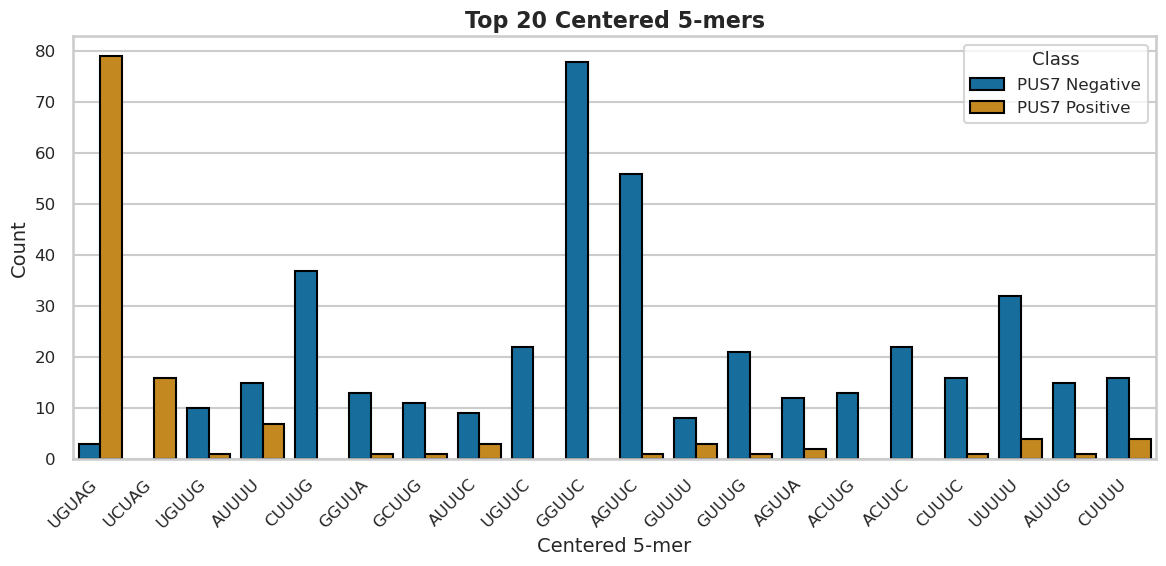

In [12]:
# top 20 centered 5-mers
top_mers = df_all['centred_5mer'].value_counts().head(20).index
plot_df = df_all[df_all['centred_5mer'].isin(top_mers)]
sns.set(style="whitegrid", context="talk")

plt.figure(figsize=(12, 6))
ax = sns.countplot(
    data=plot_df,
    x='centred_5mer',
    hue='label',
    palette='colorblind', 
    edgecolor='black')
plt.title('Top 20 Centered 5-mers', fontsize=16, weight='bold')
plt.xlabel('Centered 5-mer', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)


new_labels = ['PUS7 Negative', 'PUS7 Positive']
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, new_labels, title='Class', title_fontsize=13, fontsize=12)

plt.tight_layout()

plt.savefig("top20_5mer_wlabel2", dpi=300, bbox_inches='tight')
plt.show()
